In [1]:
import matplotlib.pyplot as plt

from utils import *
import jax.numpy as np

from optimize import *
from regression import LogisticRegression

import math

# Plotting code

Use the below function to show your line plots.

`all_data` is expected to be a list of experiments, each experiment containing:
1. "steps": an array consisting of the number of data items accessed at each step.
2. "train_loss": the train loss at each step.
3. "label": a label for the experiment

In [2]:
def plot_superimposed_line_series(all_data, classification_problem):
    for series in all_data:
        plt.plot(series['steps'], series['train_loss'], label = series['label'])   
    #
    plt.ylim(0, 1.5)
    plt.xlabel('Number of data items accessed')
    plt.ylabel('NLL')
    plt.title('Performance as a function of data access for '+classification_problem)
    plt.legend()
#

In [3]:
def gather_data(X_train, Y_train, X_val, Y_val, label_0, label_1):
    train_query = np.logical_or(Y_train==label_0, Y_train==label_1)
    val_query = np.logical_or(Y_val==label_0, Y_val==label_1)

    Y_train_query = Y_train[train_query]
    Y_train_mapped = np.where(Y_train_query == label_0, np.zeros(Y_train_query.shape[0]), np.ones(Y_train_query.shape[0]))

    Y_val_query = Y_val[val_query]
    Y_val_mapped = np.where(Y_val_query == label_0, np.zeros(Y_val_query.shape[0]), np.ones(Y_val_query.shape[0]))

    return X_train[train_query], Y_train_mapped, X_val[val_query], Y_val_mapped
#

In [4]:
dataset = 'cifar10'
X_train_all = np.load('X_'+dataset+'_train.npy')
Y_train_all = np.load('Y_'+dataset+'_train.npy')
X_val_all = np.load('X_'+dataset+'_val.npy')
Y_val_all = np.load('Y_'+dataset+'_val.npy')

cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
label_to_ind = dict([(cifar10_labels[i], i) for i in range(len(cifar10_labels))])

# The Superman split: birds vs. airplanes

In [5]:
# Let's consider the Superman split: birds vs. airplanes
X_train, Y_train, X_val, Y_val = gather_data(X_train_all, Y_train_all, X_val_all, Y_val_all, label_to_ind['bird'], label_to_ind['airplane'])

N = X_train.shape[0]
D = X_train.shape[1]

# total number of data items to access: 2^15
total_data_items = 2**15


# for GD and Newton's method, we require the training data size
T_batch = math.ceil(total_data_items / N)

# for SGD and minibatch methods
T_1 = total_data_items
T_8 = total_data_items // 8
T_32 = total_data_items // 32

# fix the seed
seed = 0

# run optimization below, with step sizes set to (L = Lipschitz constant):
# * GD: 2/L
# * Newton: 0.5
# * Minibatch & SGD: starting step size is 2/L, ending step size is 1e-2/L

lr = LogisticRegression(X_train, Y_train, X_val, Y_val, beta = 1e-1)

init_prng(seed)



Array([0, 0], dtype=uint32)

In [6]:
# define optimization params


# * GD: 2/L
print(f"Running full batch gradient descent:")
w0 = lr.initialization()
data_sampler = full_batch_sample()
loss_func = lr.train_loss
descent_func = lambda w, data_samples: lr.train_loss_and_grad(w, data_samples)[1]
T = T_batch
step_size = constant_step_size(15_000.0 / lr.lipschitz_constant()) # can replace 2 with 15000 to get it to converge
update_method = gd()
wF, losses = optimize(w0, data_sampler, loss_func, descent_func, step_size, update_method, T, verbose=True)
steps = list(total_data_items * np.arange(1, T+1))

experiment1 = {
    "steps": steps,
    "train_loss": losses,
    "label": "GD"
}

# * Newton: 0.5
print(f"Running Newton: ")
w0 = lr.initialization()
data_sampler = full_batch_sample()
loss_func = lr.train_loss
descent_func = lambda w, data_samples: lr.train_loss_and_newton(w, data_samples)[1]
T = T_batch
step_size = constant_step_size(1_500_000 / lr.lipschitz_constant()) # can replace 2 with 15000 to get it to converge
update_method = gd()
wF, losses = optimize(w0, data_sampler, loss_func, descent_func, step_size, update_method, T, verbose=True)
steps = list(total_data_items * np.arange(1, T+1))

experiment2 = {
    "steps": steps,
    "train_loss": losses,
    "label": "Newton"
}

# Minibatch 32
print(f"Running Minibatch 32: ")
w0 = lr.initialization()
data_sampler = minibatch_sampler(N, 1)
loss_func = lr.train_loss
descent_func = lambda w, data_samples: lr.train_loss_and_grad(w, data_samples)[1]
T = T_32
lip = lr.lipschitz_constant() 
step_size = diminishing_step_size(2.0 * np.sqrt(N) / lip, 1e-2 / lip, T) 
update_method = gd()
wF, losses = optimize(w0, data_sampler, loss_func, descent_func, step_size, update_method, T, verbose=True)
steps = list(total_data_items * np.arange(1, T+1))

experiment3 = {
    "steps": steps,
    "train_loss": losses,
    "label": "Minibatch 32"
}

# Minibatch 8
print(f"Running Minibatch 8")
w0 = lr.initialization()
data_sampler = minibatch_sampler(N, 1)
loss_func = lr.train_loss
descent_func = lambda w, data_samples: lr.train_loss_and_grad(w, data_samples)[1]
T = T_8
lip = lr.lipschitz_constant() 
step_size = diminishing_step_size(2.0 * np.sqrt(N) / lip, 1e-2 / lip, T) 
update_method = gd()
wF, losses = optimize(w0, data_sampler, loss_func, descent_func, step_size, update_method, T, verbose=True)
steps = list(total_data_items * np.arange(1, T+1))

experiment4 = {
    "steps": steps,
    "train_loss": losses,
    "label": "Minibatch 8"
}

# SGD
print("Running SGD")
w0 = lr.initialization()
data_sampler = minibatch_sampler(N, 1)
loss_func = lr.train_loss
descent_func = lambda w, data_samples: lr.train_loss_and_grad(w, data_samples)[1]
T = T_1
lip = lr.lipschitz_constant() 
step_size = diminishing_step_size(2.0 * np.sqrt(N) / lip, 1e-2 / lip, T) 
update_method = gd()
wF, losses = optimize(w0, data_sampler, loss_func, descent_func, step_size, update_method, T, verbose=True)
steps = list(total_data_items * np.arange(1, T+1))

experiment5 = {
    "steps": steps,
    "train_loss": losses,
    "label": "SGD"
}

all_data = [experiment1, experiment2, experiment3, experiment4, experiment5]
plot_superimposed_line_series(all_data, "all plots")




Running full batch gradient descent:


Optimizing: 100%|██████████| 6/6 [00:00<00:00, 11.13it/s, Loss=0.6438, Step size=0.0083, Update mag=0.0076]


Optimization completed. Final loss: 0.6438
Running Newton: 


Optimizing:   0%|          | 0/6 [00:00<?, ?it/s]

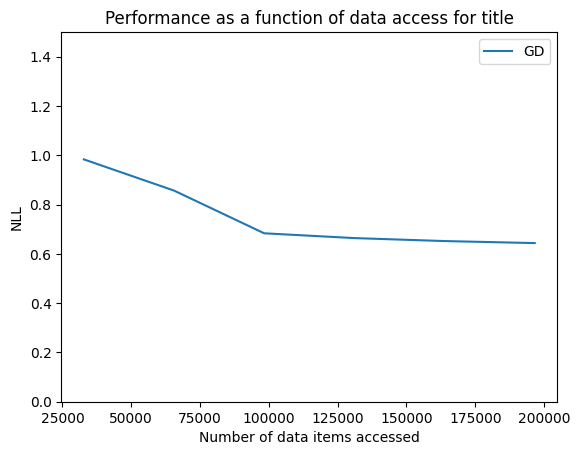

# Deer vs. horses

In [ ]:
# Now we will consider deers vs. horses
X_train, Y_train, X_val, Y_val = gather_data(X_train_all, Y_train_all, X_val_all, Y_val_all, label_to_ind['deer'], label_to_ind['horse'])

N = X_train.shape[0]
D = X_train.shape[1]

# total number of data items to access: 2^15
total_data_items = 2**15

# for GD and Newton's method, we require the training data size
T_batch = math.ceil(total_data_items / N)

# for SGD and minibatch methods
T_1 = total_data_items
T_8 = total_data_items // 8
T_32 = total_data_items // 32

# fix the seed
seed = 0

# run optimization below, with step sizes set to (L = Lipschitz constant):
# * GD: 2/L
# * Newton: .5
# * Minibatch & SGD: starting step size is 2/L, ending step size is 1e-2/L

lr = LogisticRegression(X_train, Y_train, X_val, Y_val, beta = 1e-1)

init_prng(seed)